In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install catboost

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

In [4]:
# Load the datasets
train_data = pd.read_csv("/content/drive/My Drive/5388/assignment2/traindata.csv")
test_data = pd.read_csv("/content/drive/My Drive/5388/assignment2/testdata.csv")

In [5]:
# Display basic info of the datasets
train_info = train_data.info()
test_info = test_data.info()

train_info, test_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23002 entries, 0 to 23001
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           23002 non-null  int64  
 1   duration                     23002 non-null  int64  
 2   protocol_type                23002 non-null  object 
 3   service                      23002 non-null  object 
 4   flag                         23002 non-null  object 
 5   src_bytes                    23002 non-null  int64  
 6   dst_bytes                    23002 non-null  int64  
 7   land                         23002 non-null  int64  
 8   wrong_fragment               23002 non-null  int64  
 9   urgent                       23002 non-null  int64  
 10  hot                          23002 non-null  int64  
 11  num_failed_logins            23002 non-null  int64  
 12  logged_in                    23002 non-null  int64  
 13  num_compromised 

(None, None)

In [6]:
# Check the shape of the datasets
train_shape = train_data.shape
test_shape = test_data.shape

# Check the distribution of the target variable 'Class'
class_distribution = train_data['Class'].value_counts(normalize=True)

# Check for missing values in the datasets
missing_train = train_data.isnull().sum().sum()
missing_test = test_data.isnull().sum().sum()

train_shape, test_shape, class_distribution, missing_train, missing_test

((23002, 44),
 (22501, 43),
 0    0.521737
 1    0.478263
 Name: Class, dtype: float64,
 0,
 0)

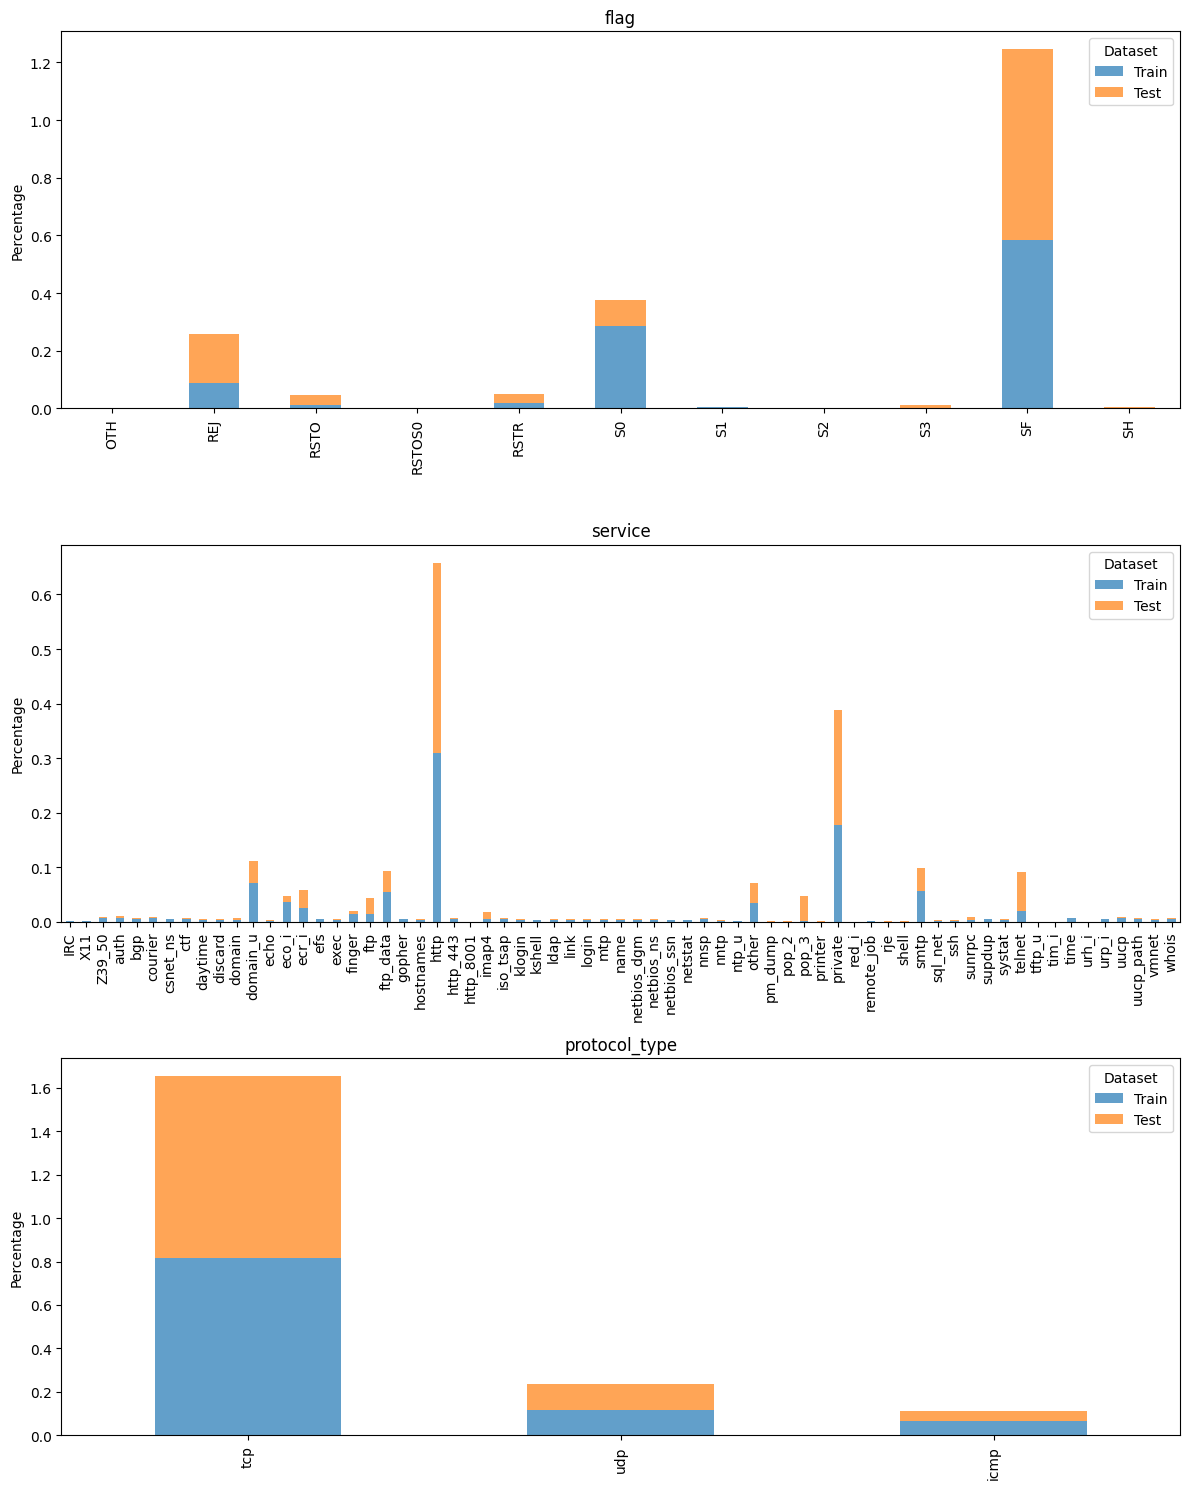

In [7]:
# Filter out categorical columns for both datasets
categorical_columns_train = train_data.select_dtypes(include=['object']).columns
categorical_columns_test = test_data.select_dtypes(include=['object']).columns

# Ensure we only consider common categorical columns in both datasets for comparison
common_categorical_columns = set(categorical_columns_train).intersection(categorical_columns_test)

# Plotting stacked bar charts for categorical columns to compare distributions in train and test data
fig, axes = plt.subplots(len(common_categorical_columns), 1, figsize=(12, 5 * len(common_categorical_columns)))

for col, ax in zip(common_categorical_columns, axes):
    # Getting value counts for each category for train and test data
    train_counts = train_data[col].value_counts(normalize=True)
    test_counts = test_data[col].value_counts(normalize=True)

    # Creating a DataFrame for easier plotting
    df = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0)

    # Plotting
    df.plot(kind='bar', stacked=True, ax=ax, alpha=0.7)
    ax.set_title(col)
    ax.set_ylabel('Percentage')
    ax.legend(title='Dataset')

plt.tight_layout()
plt.show()

In [8]:
# one-hot encoding for 'protocol_type'
train_data = pd.get_dummies(train_data, columns=['protocol_type'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['protocol_type'], drop_first=True)

# label encoding for 'service' and 'flag' in the training set
for column in ['service', 'flag']:
    le_train = LabelEncoder()
    train_data[column] = le_train.fit_transform(train_data[column])

# label encoding for 'service' and 'flag' in the testning set
for column in ['service', 'flag']:
    le_test = LabelEncoder()
    test_data[column] = le_test.fit_transform(test_data[column])

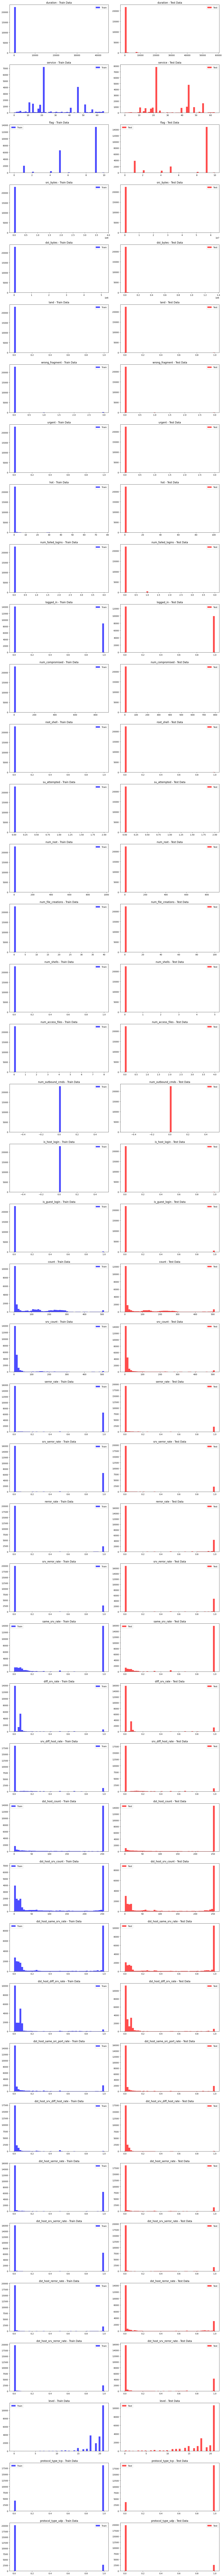

In [9]:
categorical_cols = train_data.select_dtypes(include=['object'])
# Drop ID, Class (for traindata) and categorical columns
features_to_check = train_data.drop(columns=['ID', 'Class'] + list(categorical_cols)).columns

# Plotting histograms for each feature
fig, ax = plt.subplots(len(features_to_check), 2, figsize=(15, 4 * len(features_to_check)))

for i, feature in enumerate(features_to_check):
    ax[i, 0].hist(train_data[feature], bins=50, color='blue', alpha=0.7, label='Train')
    ax[i, 0].set_title(f"{feature} - Train Data")
    ax[i, 0].legend()

    ax[i, 1].hist(test_data[feature], bins=50, color='red', alpha=0.7, label='Test')
    ax[i, 1].set_title(f"{feature} - Test Data")
    ax[i, 1].legend()

plt.tight_layout()
plt.show()

In [10]:
# Binning based on decision tree splits and store the actual bin edges
all_features = train_data.drop(columns=['ID', 'Class']).columns
actual_bin_edges = {}
y_train = train_data['Class']

for feature in all_features:
    # Train a decision tree on the feature
    tree = DecisionTreeClassifier(max_depth=2)
    tree.fit(train_data[feature].values.reshape(-1, 1), y_train)

    # Get the tree's threshold values to determine bin edges
    thresholds = np.sort(tree.tree_.threshold[tree.tree_.threshold != -2])
    actual_bin_edges[feature] = [-np.inf] + list(thresholds) + [np.inf]

    # Transform train and test data based on bin edges
    train_data[feature] = np.digitize(train_data[feature], bins=actual_bin_edges[feature]) - 1
    test_data[feature] = np.digitize(test_data[feature], bins=actual_bin_edges[feature]) - 1

In [11]:
X_train = train_data.drop(['ID','Class'], axis='columns')
y_train = train_data['Class']
X_test = test_data.drop('ID', axis='columns')

In [12]:
# Save column names
feature_names = X_train.columns.tolist()

# Data Standardization
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)

In [13]:
# Feature Selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
importances

indices = np.argsort(importances)[::-1]

# Select the names of the top 41 features
selected_features = [feature_names[i] for i in indices[:36]]

In [14]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [15]:
# Adding a validation split for early stopping
valid_size = int(len(X_train) * 0.1)
X_valid = X_train[-valid_size:]
y_valid = y_train[-valid_size:]
X_train = X_train[:-valid_size]
y_train = y_train[:-valid_size]

In [16]:
# Replace the values in the dictionary with optimal parameters
optimal_params = {
    'depth': 6,
    'learning_rate': 0.1,
    'iterations': 1000,
    'l2_leaf_reg': 3.0,  # L2 regular
    'class_weights': [1, 100],  # class weights
    'early_stopping_rounds': 100 # Early stopping
}

In [17]:
cat = CatBoostClassifier(loss_function='Logloss', eval_metric='Logloss', verbose=0, **optimal_params)
cat.fit(X_train, y_train, eval_set=(X_valid, y_valid))  # Add early stopping

In [18]:
# Predict on the test set
y_pred = cat.predict(X_test)

In [19]:
# Create submission file
submission = pd.DataFrame({'ID': test_data['ID'], 'Class': y_pred})
submission.to_csv("/content/drive/My Drive/5388/assignment2/day10/submission.csv", index=False)